## Import modules and functions

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path
%matplotlib inline
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims

## Specify experiment directory

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed Culture/STEDBIN/'
protein="TNR" #TNR,Agg,WFA,HABP

## Make dictionary for results and load aligned images from Matlab GUI

In [5]:
#make synapse results dictionary

spots={"filename":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if filelist[i].endswith(".txt"): 
        #if ("samecellonly" in str(filelist[i]))==False:
            if ("output_classification" in str(filelist[i]))==True:
                if (protein in str(filelist[i]))==True:
                     if ("backup" in str(filelist[i]))==False:
                        #if str(filelist[i][:-12]) not in str(spots["filename"]):
                            spots["filename"].append(filelist[i])


synapses_results={"spots classification filename":[],
                "sted spot":[],
                "vglut spot":[],
                "dio spot":[],
                "sted spot aligned":[],
                "vglut spot aligned":[],
                "dio spot aligned":[],
                 "sted spot aligned no back":[],
                "vglut spot aligned no back":[],
                "dio spot aligned no back":[],
                "Exp name":[],
                "Cell number":[],
                "unique id (expname_cell number)":[],
                "classification":[],
                  "mean ecm intensity sted":[],
                  "ecm intensity sted, bg subtracted":[],
                  "mean ecm intensity sted noback":[],
                  "ecm intensity sted noback bg subtracted":[],
                  "mean vglut intensity sted":[],
                  "vglut intensity sted, bg subtracted":[],
                  "mean vglut intensity sted noback":[],
                  "vglut intensity sted noback bg subtracted":[],
                  "mean vglut size (sum of pixels)":[],
                  "mean vglut size (sum of pixels) from noback":[],
                  "exp condition":[]}
                  
num=0
for spot in range(0,len(spots["filename"])):
    num+=1
    print(spots["filename"][spot])
    firstpart='/'.join(spots["filename"][spot].split("/")[:-1])
    lastpart=spots["filename"][spot].split("classification")[-1]
    synapses_results["spots classification filename"].append(spots["filename"][spot])
    file2read=firstpart+'/output_sted_'+lastpart
    synapses_results["sted spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_homer_'+lastpart
    synapses_results["vglut spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_dio_'+lastpart
    synapses_results["dio spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_sted_aligned_'+lastpart
    synapses_results["sted spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_homer_aligned_'+lastpart
    synapses_results["vglut spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_dio_aligned_'+lastpart
    synapses_results["dio spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_sted_aligned_noback_'+lastpart
    synapses_results["sted spot aligned no back"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_homer_aligned_noback_'+lastpart
    synapses_results["vglut spot aligned no back"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_dio_aligned_noback_'+lastpart
    synapses_results["dio spot aligned no back"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    
    synapses_results["Exp name"].append(file2read.split("2019")[-1][0:4])
    synapses_results["Cell number"].append(lastpart[-9:-4])
    synapses_results["unique id (expname_cell number)"].append(file2read.split("2019")[-1][0:4]+'_'+lastpart[-9:-4])
    synapses_results["classification"].append(np.loadtxt(spots["filename"][spot]))
    synapses_results["exp condition"].append(synapses_results["spots classification filename"][spot].split("TIFs")[-1].split('/')[1])
    
    synapses_results["mean ecm intensity sted"].append(np.nan)
    synapses_results["ecm intensity sted, bg subtracted"].append(np.nan)
    synapses_results["mean ecm intensity sted noback"].append(np.nan)
    synapses_results["ecm intensity sted noback bg subtracted"].append(np.nan)
    synapses_results["mean vglut intensity sted"].append(np.nan)
    synapses_results["vglut intensity sted, bg subtracted"].append(np.nan)
    synapses_results["mean vglut intensity sted noback"].append(np.nan)
    synapses_results["vglut intensity sted noback bg subtracted"].append(np.nan)
    synapses_results["mean vglut size (sum of pixels)"].append(np.nan)
    synapses_results["mean vglut size (sum of pixels) from noback"].append(np.nan)
clear_output() 

## Tot. no. synapses read

In [7]:
len(synapses_results["spots classification filename"])

1620

## Make dictionary for individual synapse (spot) images

In [8]:
for spotno in range(0,len(synapses_results["spots classification filename"])):
    synapses_results["mean ecm intensity sted"][spotno]=np.nanmean(synapses_results["sted spot aligned"][spotno])
    synapses_results["mean ecm intensity sted noback"][spotno]=np.nanmean(synapses_results["sted spot aligned no back"][spotno])
    synapses_results["mean vglut intensity sted"][spotno]=np.nanmean(synapses_results["vglut spot aligned"][spotno])
    synapses_results["mean vglut intensity sted noback"][spotno]=np.nanmean(synapses_results["vglut spot aligned no back"][spotno])
    synapses_results["mean vglut size (sum of pixels)"][spotno]=np.sum(synapses_results["vglut spot aligned"][spotno])
    synapses_results["mean vglut size (sum of pixels) from noback"][spotno]=np.sum(synapses_results["vglut spot aligned no back"][spotno])

    #bg subtraction
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["sted spot aligned"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["ecm intensity sted, bg subtracted"][spotno]=(ecm_around_spot_bgsub)
    
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["sted spot aligned no back"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["ecm intensity sted noback bg subtracted"][spotno]=(ecm_around_spot_bgsub)
    
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["vglut spot aligned"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["vglut intensity sted, bg subtracted"][spotno]=(ecm_around_spot_bgsub)
    
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["vglut spot aligned no back"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["vglut intensity sted noback bg subtracted"][spotno]=(ecm_around_spot_bgsub)

## Make dataframe for spots images

In [9]:
df=pd.DataFrame(synapses_results)
#make df, which also contains column names for plotting (drug, condition)
df['Time']='None'
df.loc[df["spots classification filename"].str.contains('12hr'), 'Time'] = '12hrs'
df.loc[df['spots classification filename'].str.contains('Ctrl'), 'Time'] = 'Unblocked Control'
df.loc[df['spots classification filename'].str.contains('Unblocked'), 'Time'] = 'Unblocked Control'

df.loc[df['spots classification filename'].str.contains('Bic'), 'Drug'] = 'Bic'
df.loc[df['spots classification filename'].str.contains('DMSO'), 'Drug'] = 'DMSO'
df.loc[df['spots classification filename'].str.contains('Ctrl'), 'Drug'] = 'DMSO'
df.loc[df['spots classification filename'].str.contains('Unblocked'), 'Drug'] = 'DMSO'

#nicely written treatment condition for plotting
df['Condition']='None'
df.loc[df['spots classification filename'].str.contains('12hrs_Bic'), 'Condition'] = '12hr + Bic'
df.loc[df['spots classification filename'].str.contains('12hrs_DMSO'), 'Condition'] = '12hr + DMSO'
df.loc[df['spots classification filename'].str.contains('12hr_Bic'), 'Condition'] = '12hr + Bic'
df.loc[df['spots classification filename'].str.contains('12hr_DMSO'), 'Condition'] = '12hr + DMSO'
df.loc[df['spots classification filename'].str.contains('Ctrl'), 'Condition'] = 'Unblocked Control'
df.loc[df['spots classification filename'].str.contains('Unblocked'), 'Condition'] = 'Unblocked Control'

df["expname"]='None'
df.loc[df['spots classification filename'].str.contains('20190216'), 'expname'] = '20190216_TNR580_DiO_VGlut647'
df.loc[df['spots classification filename'].str.contains('20190225'), 'expname'] = '20190225_TNR647_VGlut580_DiO'
df.loc[df['spots classification filename'].str.contains('20190302'), 'expname'] = '20190302_TNR647_Vglut580_DiO'
df.loc[df['spots classification filename'].str.contains('20190307'), 'expname'] = '20190307_TNR647_VGlut580_DiO_analyse'

df["Type"]='None'
df.loc[df["classification"]==1,"Type"]="Mushroom"
df.loc[df["classification"]==2,"Type"]="Flat"
df.loc[df["classification"]==3,"Type"]="Bouton"

df["Epitopes and drug"]='None'
df.loc[df["Condition"]=="Unblocked Control","Epitopes"]="All (unblocked)"
df.loc[df["Condition"]=="12hr + Bic","Epitopes"]="New + bic"
df.loc[df["Condition"]=="12hr + DMSO","Epitopes"]="New + dmso"

df["Epitopes old/new"]='None'
df.loc[df["Condition"]=="Unblocked Control","Epitopes old/new"]="All (unblocked)"
df.loc[df["Condition"]=="12hr + Bic","Epitopes old/new"]="New (any drug)"
df.loc[df["Condition"]=="12hr + DMSO","Epitopes old/new"]="New (any drug)"

## Display a random spots image

In [1]:
randomno=np.random.randint(1,len(df))
fig=plt.figure(figsize=(20,20))
fig.add_subplot(131)
plt.imshow(df["vglut spot aligned"][randomno],cmap='inferno')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('VGlut spot')
fig.add_subplot(132)
plt.imshow(df["sted spot aligned"][randomno],cmap='inferno')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('ECM around synapse spot')
fig.add_subplot(133)
plt.imshow(df["dio spot aligned"][randomno],cmap='jet')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('dio around synapse spot')

NameError: name 'np' is not defined

## Add mean intensity normalized by corresponding experiment median

In [11]:
df["mean ecm intensity sted, bg subtracted"]=np.nan
df["mean vglut intensity sted, bg subtracted"]=np.nan
for i in range(0,len(df)):
    df["mean ecm intensity sted, bg subtracted"][i]=df["ecm intensity sted, bg subtracted"][i].mean()
    df["mean vglut intensity sted, bg subtracted"][i]=df["vglut intensity sted, bg subtracted"][i].mean()
df2=deepcopy(df)
df2=df2.reset_index()
df2["ecm mean int norm2med"]=df2["mean ecm intensity sted, bg subtracted"]
df2["vglut mean int norm2med"]=df2["mean vglut intensity sted, bg subtracted"]
expnam=[]
medtnr=[]
medvglut=[]
for exp in df2["expname"].unique():
    dfexp=df2[df2["expname"]==exp]
    med_tnr=dfexp["mean ecm intensity sted, bg subtracted"].median()
    med_vglut=dfexp["mean vglut intensity sted, bg subtracted"].median()
    print(exp+' - med tnr: '+str(med_tnr)+' - med vglut: '+str(med_vglut))
    expnam.append(exp)
    medtnr.append(med_tnr)
    medvglut.append(med_vglut)
df2["ecm mean int norm2med"]=np.nan
df2["vglut mean int norm2med"]=np.nan
df2["ecm int norm2med"]=df2["ecm intensity sted, bg subtracted"]
df2["vglut int norm2med"]=df2["vglut intensity sted, bg subtracted"]
for i in range(0,len(df2)):
    if df2["expname"][i]==expnam[0]:
        df2["ecm mean int norm2med"][i]=df2["mean ecm intensity sted, bg subtracted"][i]/medtnr[0]
        df2["vglut mean int norm2med"][i]=df2["mean vglut intensity sted, bg subtracted"][i]/medvglut[0]
        df2["ecm int norm2med"][i]=np.divide(df2["ecm intensity sted, bg subtracted"][i],medtnr[0])
        df2["vglut int norm2med"][i]=np.divide(df2["vglut intensity sted, bg subtracted"][i],medvglut[0])
    if df2["expname"][i]==expnam[1]:
        df2["ecm mean int norm2med"][i]=df2["mean ecm intensity sted, bg subtracted"][i]/medtnr[1]
        df2["vglut mean int norm2med"][i]=df2["mean vglut intensity sted, bg subtracted"][i]/medvglut[1]
        df2["ecm int norm2med"][i]=np.divide(df2["ecm intensity sted, bg subtracted"][i],medtnr[1])
        df2["vglut int norm2med"][i]=np.divide(df2["vglut intensity sted, bg subtracted"][i],medvglut[1])
    if df2["expname"][i]==expnam[2]:
        df2["ecm mean int norm2med"][i]=df2["mean ecm intensity sted, bg subtracted"][i]/medtnr[2]
        df2["vglut mean int norm2med"][i]=df2["mean vglut intensity sted, bg subtracted"][i]/medvglut[2]
        df2["ecm int norm2med"][i]=np.divide(df2["ecm intensity sted, bg subtracted"][i],medtnr[2])
        df2["vglut int norm2med"][i]=np.divide(df2["vglut intensity sted, bg subtracted"][i],medvglut[2])
    if df2["expname"][i]==expnam[3]:
        df2["ecm mean int norm2med"][i]=df2["mean ecm intensity sted, bg subtracted"][i]/medtnr[3]
        df2["vglut mean int norm2med"][i]=df2["mean vglut intensity sted, bg subtracted"][i]/medvglut[3]
        df2["ecm int norm2med"][i]=np.divide(df2["ecm intensity sted, bg subtracted"][i],medtnr[3])
        df2["vglut int norm2med"][i]=np.divide(df2["vglut intensity sted, bg subtracted"][i],medvglut[3])

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


20190216_TNR580_DiO_VGlut647 - med tnr: 0.008326720209740911 - med vglut: 1.283467670034585
20190225_TNR647_VGlut580_DiO - med tnr: 0.10152021464699115 - med vglut: 1.3023165773348664
20190302_TNR647_Vglut580_DiO - med tnr: 0.1061154624645971 - med vglut: 0.6236793832649349
20190307_TNR647_VGlut580_DiO_analyse - med tnr: 0.22207896580905692 - med vglut: 0.5101576644743427


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning

## Add mean intensity normalized to unblocked control of that experiment

In [12]:
expnam=[]
unblockedtnr=[]
unblockedvglut=[]
for exp in df2["expname"].unique():
    dfexp=df2[df2["expname"]==exp]
    ub_tnr=dfexp[dfexp["Condition"]=="Unblocked Control"]["mean ecm intensity sted, bg subtracted"].mean()
    ub_vglut=dfexp[dfexp["Condition"]=="Unblocked Control"]["mean vglut intensity sted, bg subtracted"].mean()
    print(exp+' - ub tnr: '+str(ub_tnr)+' - ub vglut: '+str(ub_vglut))
    expnam.append(exp)
    unblockedtnr.append(ub_tnr)
    unblockedvglut.append(ub_vglut)
df2["ecm mean int norm2unblocked"]=np.nan
df2["vglut mean int norm2unblocked"]=np.nan
df2["ecm int norm2unblocked"]=df2["ecm intensity sted, bg subtracted"]
df2["vglut int norm2unblocked"]=df2["vglut intensity sted, bg subtracted"]
for i in range(0,len(df2)):
    if df2["expname"][i]==expnam[0]:
        df2["ecm mean int norm2unblocked"][i]=df2["mean ecm intensity sted, bg subtracted"][i]/unblockedtnr[0]
        df2["vglut mean int norm2unblocked"][i]=df2["mean vglut intensity sted, bg subtracted"][i]/unblockedvglut[0]
        df2["ecm int norm2unblocked"][i]=np.divide(df2["ecm intensity sted, bg subtracted"][i],unblockedtnr[0])
        df2["vglut int norm2unblocked"][i]=np.divide(df2["vglut intensity sted, bg subtracted"][i],unblockedvglut[0])
    if df2["expname"][i]==expnam[1]:
        df2["ecm mean int norm2unblocked"][i]=df2["mean ecm intensity sted, bg subtracted"][i]/unblockedtnr[1]
        df2["vglut mean int norm2unblocked"][i]=df2["mean vglut intensity sted, bg subtracted"][i]/unblockedvglut[1]
        df2["ecm int norm2unblocked"][i]=np.divide(df2["ecm intensity sted, bg subtracted"][i],unblockedtnr[1])
        df2["vglut int norm2unblocked"][i]=np.divide(df2["vglut intensity sted, bg subtracted"][i],unblockedvglut[1])
    if df2["expname"][i]==expnam[2]:
        df2["ecm mean int norm2unblocked"][i]=df2["mean ecm intensity sted, bg subtracted"][i]/unblockedtnr[2]
        df2["vglut mean int norm2unblocked"][i]=df2["mean vglut intensity sted, bg subtracted"][i]/unblockedvglut[2]
        df2["ecm int norm2unblocked"][i]=np.divide(df2["ecm intensity sted, bg subtracted"][i],unblockedtnr[2])
        df2["vglut int norm2unblocked"][i]=np.divide(df2["vglut intensity sted, bg subtracted"][i],unblockedvglut[2])
    if df2["expname"][i]==expnam[3]:
        df2["ecm mean int norm2unblocked"][i]=df2["mean ecm intensity sted, bg subtracted"][i]/unblockedtnr[3]
        df2["vglut mean int norm2unblocked"][i]=df2["mean vglut intensity sted, bg subtracted"][i]/unblockedvglut[3]
        df2["ecm int norm2unblocked"][i]=np.divide(df2["ecm intensity sted, bg subtracted"][i],unblockedtnr[3])
        df2["vglut int norm2unblocked"][i]=np.divide(df2["vglut intensity sted, bg subtracted"][i],unblockedvglut[3])

20190216_TNR580_DiO_VGlut647 - ub tnr: 0.03504584577149519 - ub vglut: 2.2045963565937012
20190225_TNR647_VGlut580_DiO - ub tnr: 0.2558247475901424 - ub vglut: 1.6615455276961448
20190302_TNR647_Vglut580_DiO - ub tnr: 0.5304934434871987 - ub vglut: 0.7456106262799833
20190307_TNR647_VGlut580_DiO_analyse - ub tnr: 0.4935249891892497 - ub vglut: 0.6583389625317414


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning

## Make separate dataframes for exp conditions and morphologies

Backup

In [13]:
df3=deepcopy(df2)

In [322]:
df2=deepcopy(df3)

In [338]:
df2=df2[df2["expname"]!="20190216_TNR580_DiO_VGlut647"]
df2_newepitopes_dmso=df2[(df2["Condition"]!="Unblocked Control")&
                         (df2["Drug"]=="DMSO")]
df2_newepitopes_bic=df2[(df2["Condition"]!="Unblocked Control")&
                         (df2["Drug"]=="Bic")]
df2_newepitopes_all=df2[(df2["Condition"]!="Unblocked Control")]

df2_unblocked=df2[df2["Condition"]=="Unblocked Control"]

df2mushrooms_unblocked=df2_unblocked[df2_unblocked["classification"]==1.0]
df2flats_unblocked=df2_unblocked[df2_unblocked["classification"]==2.0]
df2boutons_unblocked=df2_unblocked[df2_unblocked["classification"]==3.0]

df2mushrooms_newepitopes_all=df2_newepitopes_all[df2_newepitopes_all["classification"]==1.0]
df2flats_newepitopes_all=df2_newepitopes_all[df2_newepitopes_all["classification"]==2.0]
df2boutons_newepitopes_all=df2_newepitopes_all[df2_newepitopes_all["classification"]==3.0]

df2mushrooms_newepitopes_bic=df2_newepitopes_bic[df2_newepitopes_bic["classification"]==1.0]
df2flats_newepitopes_bic=df2_newepitopes_bic[df2_newepitopes_bic["classification"]==2.0]
df2boutons_newepitopes_bic=df2_newepitopes_bic[df2_newepitopes_bic["classification"]==3.0]

df2mushrooms_newepitopes_dmso=df2_newepitopes_dmso[df2_newepitopes_dmso["classification"]==1.0]
df2flats_newepitopes_dmso=df2_newepitopes_dmso[df2_newepitopes_dmso["classification"]==2.0]
df2boutons_newepitopes_dmso=df2_newepitopes_dmso[df2_newepitopes_dmso["classification"]==3.0]

## No. synapses

In [339]:
len(df2)

1439

## Make average images, all conditions, all morphologies

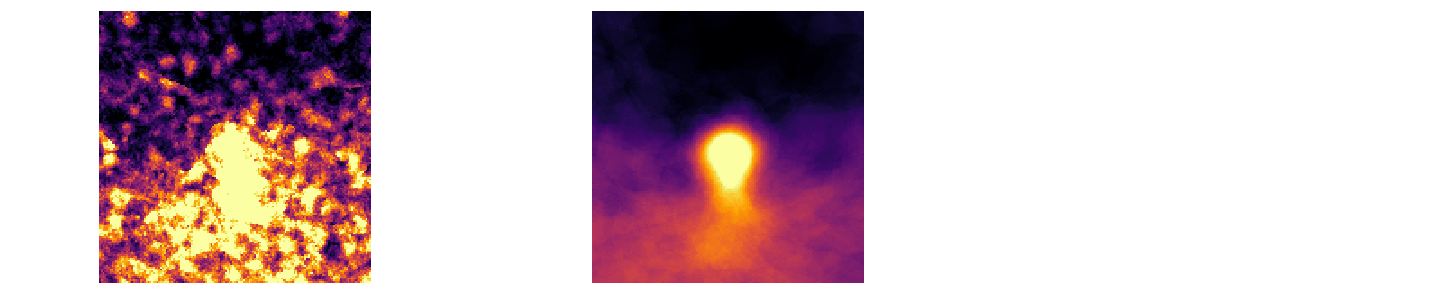

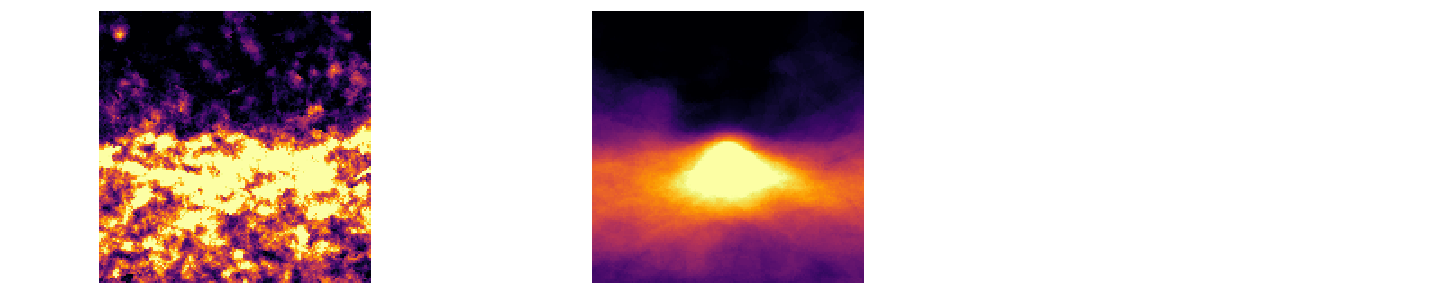

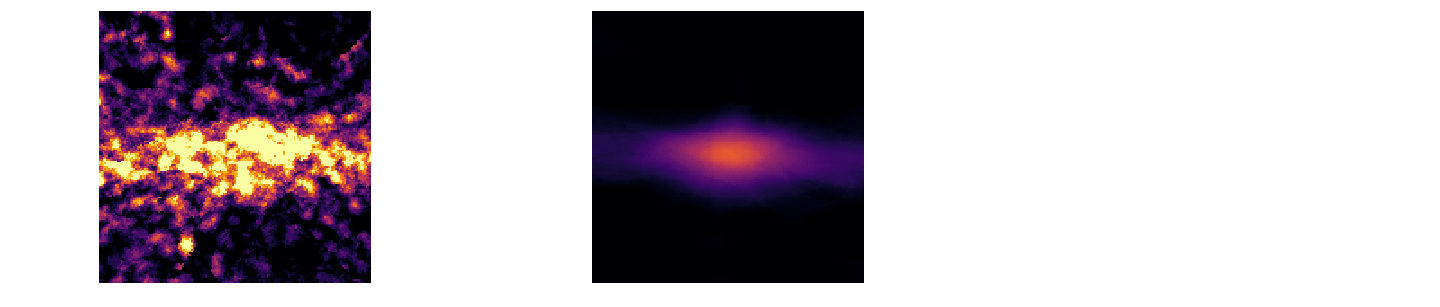

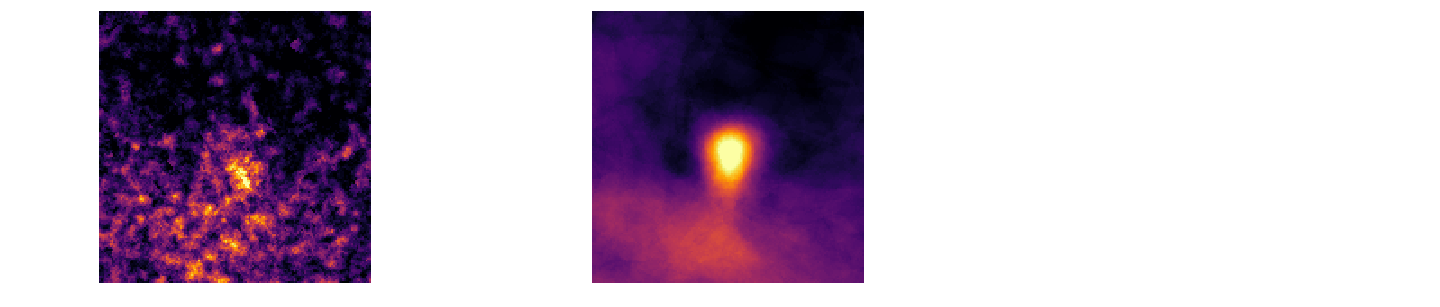

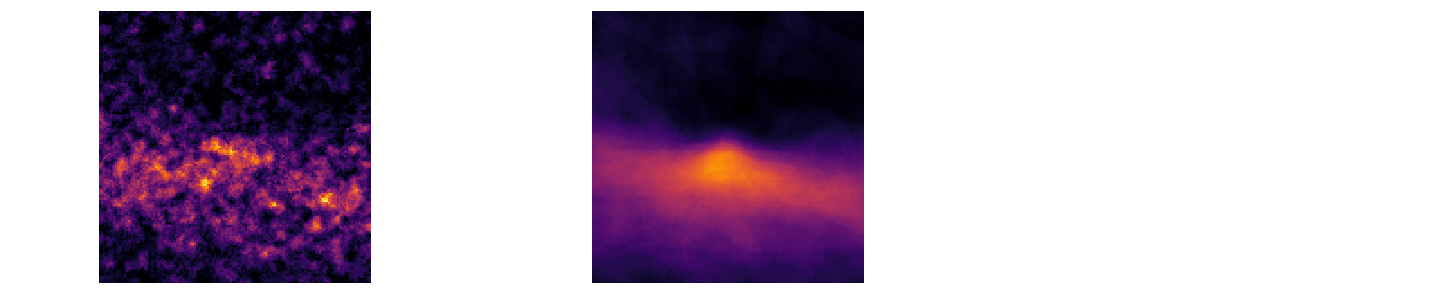

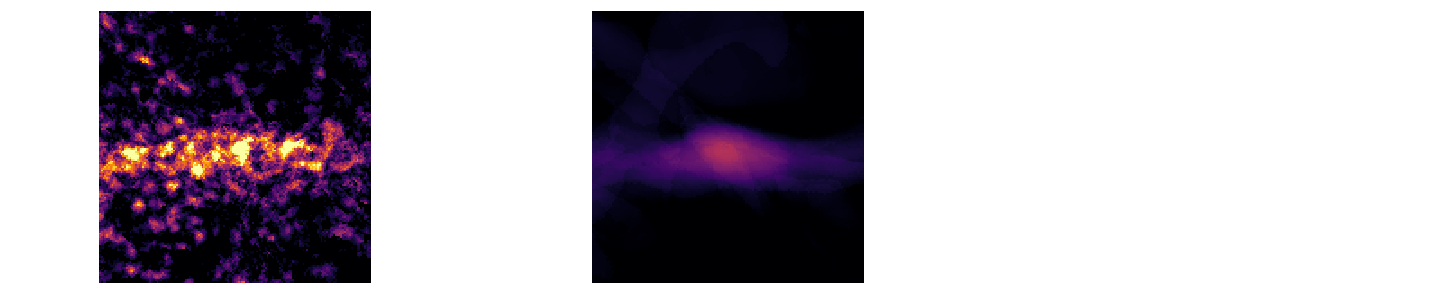

In [17]:
var="ecm intensity sted, bg subtracted"
diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"

df22plot=df2mushrooms_unblocked
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(131)
plt.imshow(df22plot[var].mean()
           ,cmap='inferno',
           vmin=df2[var].mean().min(),
           vmax=np.max(df2[var].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot[var].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_mushrooms_unblocked_sted.tiff')

fig.add_subplot(132)
plt.imshow(df22plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2["dio spot aligned"].mean()),
           vmax=np.max(df2["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["dio spot aligned"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_mushrooms_unblocked_dio.tiff')


######################################################################################################################

df22plot=df2flats_unblocked
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(131)
plt.imshow(df22plot[var].mean()
           ,cmap='inferno',
           vmin=df2[var].mean().min(),
           vmax=np.max(df2[var].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot[var].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_flats_unblocked_sted.tiff')

fig.add_subplot(132)
plt.imshow(df22plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2["dio spot aligned"].mean()),
           vmax=np.max(df2["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["dio spot aligned"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_flats_unblocked_dio.tiff')

######################################################################################################################

df22plot=df2boutons_unblocked
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(131)
plt.imshow(df22plot[var].mean()
           ,cmap='inferno',
           vmin=df2[var].mean().min(),
           vmax=np.max(df2[var].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot[var].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_boutons_unblocked_sted.tiff')

fig.add_subplot(132)
plt.imshow(df22plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2["dio spot aligned"].mean()),
           vmax=np.max(df2["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["dio spot aligned"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_boutons_unblocked_dio.tiff')

######################################################################################################################

df22plot=df2mushrooms_newepitopes_dmso
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(131)
plt.imshow(df22plot[var].mean()
           ,cmap='inferno',
           vmin=df2[var].mean().min(),
           vmax=np.max(df2[var].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot[var].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_mushrooms_newepitopes_sted.tiff')

fig.add_subplot(132)
plt.imshow(df22plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2["dio spot aligned"].mean()),
           vmax=np.max(df2["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["dio spot aligned"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_mushrooms_newepitopes_dio.tiff')
######################################################################################################################

df22plot=df2flats_newepitopes_dmso
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(131)
plt.imshow(df22plot[var].mean()
           ,cmap='inferno',
           vmin=df2[var].mean().min(),
           vmax=np.max(df2[var].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot[var].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_flats_newepitopes_sted.tiff')



fig.add_subplot(132)
plt.imshow(df22plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2["dio spot aligned"].mean()),
           vmax=np.max(df2["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["dio spot aligned"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_flats_newepitopes_dio.tiff')

######################################################################################################################
df22plot=df2boutons_newepitopes_dmso
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(131)
plt.imshow(df22plot[var].mean()
           ,cmap='inferno',
           vmin=df2[var].mean().min(),
           vmax=np.max(df2[var].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot[var].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_boutons_newepitopes_sted.tiff')



fig.add_subplot(132)
plt.imshow(df22plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2["dio spot aligned"].mean()),
           vmax=np.max(df2["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["dio spot aligned"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_boutons_newepitopes_dio.tiff')

## Plot new epitopes + bic average images

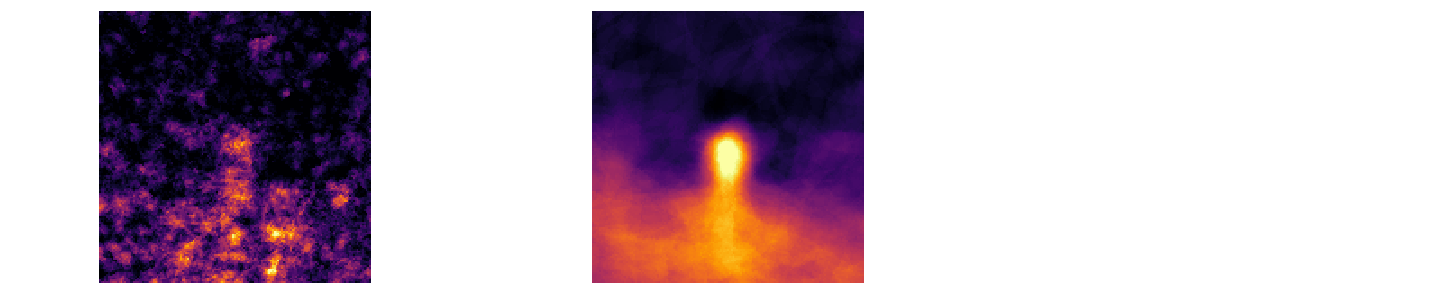

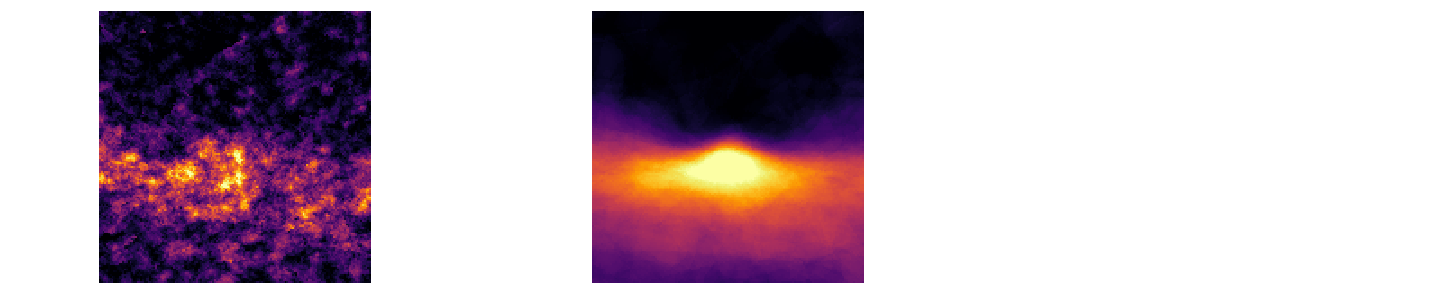

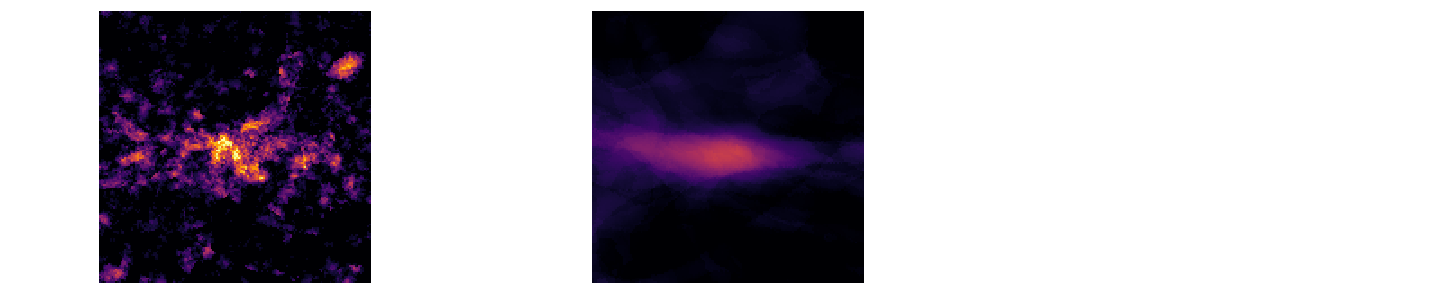

In [18]:
diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"


df22plot=df2mushrooms_newepitopes_bic
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(131)
plt.imshow(df22plot["ecm intensity sted, bg subtracted"].mean()
           ,cmap='inferno',
           vmin=df2["ecm intensity sted, bg subtracted"].mean().min(),
           vmax=np.max(df2["ecm intensity sted, bg subtracted"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["ecm intensity sted, bg subtracted"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_mushrooms_newepitopesbic_sted.tiff')

fig.add_subplot(132)
plt.imshow(df22plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2["dio spot aligned"].mean()),
           vmax=np.max(df2["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["dio spot aligned"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_mushrooms_newepitopesbic_dio.tiff')
######################################################################################################################

df22plot=df2flats_newepitopes_bic
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(131)
plt.imshow(df22plot["ecm intensity sted, bg subtracted"].mean()
           ,cmap='inferno',
           vmin=df2["ecm intensity sted, bg subtracted"].mean().min(),
           vmax=np.max(df2["ecm intensity sted, bg subtracted"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["ecm intensity sted, bg subtracted"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_flats_newepitopesbic_sted.tiff')



fig.add_subplot(132)
plt.imshow(df22plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2["dio spot aligned"].mean()),
           vmax=np.max(df2["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["dio spot aligned"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_flats_newepitopesbic_dio.tiff')

######################################################################################################################
df22plot=df2boutons_newepitopes_bic
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(131)
plt.imshow(df22plot["ecm intensity sted, bg subtracted"].mean()
           ,cmap='inferno',
           vmin=df2["ecm intensity sted, bg subtracted"].mean().min(),
           vmax=np.max(df2["ecm intensity sted, bg subtracted"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["ecm intensity sted, bg subtracted"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_boutons_newepitopesbic_sted.tiff')



fig.add_subplot(132)
plt.imshow(df22plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2["dio spot aligned"].mean()),
           vmax=np.max(df2["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
#plt.gca().add_artist(scalebar)
plt.axis('off')
data=df22plot["dio spot aligned"].mean()
im = Image.fromarray(data)
im.save(diri+'figure2_boutons_newepitopesbic_dio.tiff')

## Add more labels to df

In [327]:
df2["Epitopes old/new"]='None'
df2.loc[df2["Condition"]=="Unblocked Control","Epitopes old/new"]="All (unblocked)"
df2.loc[df2["Condition"]=="12hr + Bic","Epitopes old/new"]="New"
df2.loc[df2["Condition"]=="12hr + DMSO","Epitopes old/new"]="New"
df2["Drug"]='None'
df2.loc[df2["Condition"]=="12hr + Bic","Drug"]="Bic"
df2.loc[df2["Condition"]=="12hr + DMSO","Drug"]="DMSO"
df2["Cond_type"]='None'
df2.loc[(df2["Condition"]=="12hr + Bic")&(df2["Type"]=="Mushroom"),"Cond_type"]="New, bic, mushroom"
df2.loc[(df2["Condition"]=="12hr + DMSO")&(df2["Type"]=="Mushroom"),"Cond_type"]="New, dmso, mushroom"
df2.loc[(df2["Condition"]=="12hr + Bic")&(df2["Type"]=="Flat"),"Cond_type"]="New, bic, flat"
df2.loc[(df2["Condition"]=="12hr + DMSO")&(df2["Type"]=="Flat"),"Cond_type"]="New, dmso, flat"
df2.loc[(df2["Condition"]=="12hr + Bic")&(df2["Type"]=="Bouton"),"Cond_type"]="New, bic, bouton"
df2.loc[(df2["Condition"]=="12hr + DMSO")&(df2["Type"]=="Bouton"),"Cond_type"]="New, dmso, bouton"

df2.loc[(df2["Condition"]=="Unblocked Control")&(df2["Type"]=="Mushroom"),"Cond_type"]="All, mushroom"
df2.loc[(df2["Condition"]=="Unblocked Control")&(df2["Type"]=="Flat"),"Cond_type"]="All, flat"
df2.loc[(df2["Condition"]=="Unblocked Control")&(df2["Type"]=="Bouton"),"Cond_type"]="All, bouton"

## Plot TNR intensity for mush/flat in different conditions

In [325]:
df2["expname"].unique()

array(['20190216_TNR580_DiO_VGlut647', '20190225_TNR647_VGlut580_DiO',
       '20190302_TNR647_Vglut580_DiO',
       '20190307_TNR647_VGlut580_DiO_analyse'], dtype=object)

In [3]:
df4=deepcopy(df2[df2["Type"]!="Bouton"])

vari="vglut mean int norm2unblocked"
vari="mean vglut intensity sted, bg subtracted"
#vari="ecm mean int norm2unblocked"
vari="mean vglut intensity sted"
vari2="ecm mean int norm2unblocked"
#vari=var
vari2="mean ecm intensity sted"
quant=.95
quanti2=.95
quanti=.00

for i in range(0,len(df4["Cond_type"].unique())):
    cond=df4["Cond_type"].unique()[i]
    print(cond)
    if i==0:
        dfnewi=df4[df4["Cond_type"]==cond]
        dfnewi=dfnewi[dfnewi[vari]<
            dfnewi[vari].quantile(quant)]
        dfnewi=dfnewi[dfnewi[vari2]<
            dfnewi[vari2].quantile(quanti2)]
        print(len(dfnewi))
        print(dfnewi[var].mean())
    else:
        dfnew=df4[df4["Cond_type"]==cond]
        dfnew=dfnew[dfnew[vari]<
                dfnew[vari].quantile(quant)]
        dfnew=dfnew[dfnew[vari]>
                dfnew[vari].quantile(quanti)]
        dfnew=dfnew[dfnew[vari2]<
            dfnew[vari2].quantile(quanti2)]
        print(len(dfnew))
        print(dfnew[var].mean())
    if i>0:
        dfnewi=pd.concat([dfnewi,dfnew])

NameError: name 'deepcopy' is not defined

In [373]:
df4=deepcopy(df2)
from scipy import stats

df4=df4[df4[var]<(np.abs(stats.zscore(df4[var])) < 3).(axis=1)]

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [386]:
df4=deepcopy(df2)


df4=df4[np.abs(stats.zscore(df4[var])) < 2]

In [2]:

df2plot=dfnewi.reset_index(drop=True)



unblockedmush=df2plot[df2plot["Cond_type"]=="All, mushroom"][var].dropna().values
unblockedflat=df2plot[df2plot["Cond_type"]=="All, flat"][var].dropna().values

newmushdmso=df2plot[df2plot["Cond_type"]=="New, dmso, mushroom"][var].dropna().values
newflatdmso=df2plot[df2plot["Cond_type"]=="New, dmso, flat"][var].dropna().values

newmushbic=df2plot[df2plot["Cond_type"]=="New, bic, mushroom"][var].dropna().values
newflatbic=df2plot[df2plot["Cond_type"]=="New, bic, flat"][var].dropna().values


[stat,pval_1]=stats.ttest_ind(unblockedmush, unblockedflat)
[stat,pval_2]=stats.ttest_ind(newmushdmso, newflatdmso)
[stat,pval_3]=stats.ttest_ind(newmushbic, newflatbic)

print(pval_1)
print(pval_2)
print(pval_3)

NameError: name 'dfnewi' is not defined

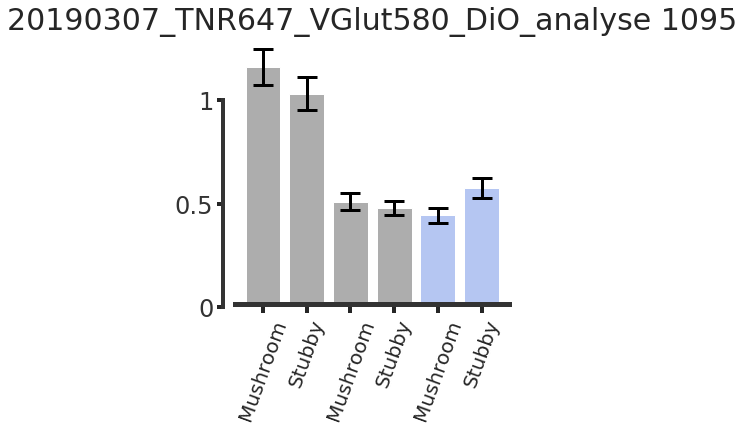

In [320]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker
#var="ecm mean int norm2med"
#var="mean ecm intensity sted noback"
var="ecm mean int norm2unblocked"
#var="mean ecm intensity sted"
#var="ecm mean int norm2med"
#var="mean ecm intensity sted, bg subtracted"

df2plot=dfnewi.reset_index(drop=True)
#df2plot=df2plot[df2plot[var]<
#df2plot[var].quantile(.99)]
#df2plot=df2plot[df2plot["mean ecm intensity sted, bg subtracted"]<
 #              df2plot["mean ecm intensity sted, bg subtracted"].quantile(.99)]
#df2plot=df2plot[df2plot["vglut mean int norm2unblocked"]<
                #df2plot["vglut mean int norm2unblocked"].quantile(.9999)]
#df2plot=df2plot[df2plot["vglut mean int norm2unblocked"]>
               # df2plot["vglut mean int norm2unblocked"].quantile(.0001)]
#df2plot=df2plot[df2plot["mean vglut intensity sted, bg subtracted"]>
#                df2plot["mean vglut intensity sted, bg subtracted"].quantile(.0)]
#df2plot=df2plot[df2plot["mean vglut intensity sted, bg subtracted"]<
 #               df2plot["mean vglut intensity sted, bg subtracted"].quantile(.99)]
#df2plot=df2plot[df2plot["mean ecm intensity sted, bg subtracted"]<
#                df2plot["mean ecm intensity sted, bg subtracted"].quantile(.99)]

#var="mean ecm intensity sted noback"
#var="ecm mean int norm2unblocked"
#var="ecm mean int norm2med"
#var="mean ecm intensity sted, bg subtracted"
fig=plt.figure(figsize=(5,5))
palette={"All, mushroom": "#adadad",
         "All, flat": "#adadad",
         "New, dmso, mushroom":"#adadad",
         "New, dmso, flat":"#adadad",
        "New, bic, mushroom":"#abc2fc",
         "New, bic, flat":"#abc2fc"}
order=["All, mushroom","All, flat","New, dmso, mushroom","New, dmso, flat",
      "New, bic, mushroom","New, bic, flat"]

g=sns.barplot(data=df2plot,y=var,x="Cond_type"
            ,order=order,palette=palette,ci=None)
plt.title(exp+" "+str(len(df2plot)))
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
change_width(g, .8)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Cond_type"]==condtype][var].mean() for condtype in order],
             yerr=[df2plot[df2plot["Cond_type"]==condtype][var].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

#plt.ylim([0,0.5])
plt.axhline(0, color='#333333',alpha=1,linewidth=10)


scale_y=1/1
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
g.yaxis.set_major_formatter(ticks_y)
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)
plt.rcParams['font.sans-serif'] = 'Helvetica'
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),['Mushroom','Stubby','Mushroom','Stubby','Mushroom','Stubby'],
           rotation=70,size=20)
plt.yticks(g.get_yticks(),size=24,color='#333333')
g.grid(False)


'''x1, x2 = 0,1
y= 0.45
h=0.005
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=24, weight='bold')

x1, x2 = 2,3
y= 0.25
h=0.005
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=24, weight='bold')

x1, x2 = 4,5
y= 0.25
h=0.005
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=24, weight='bold')'''

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
#fig.savefig(diri+'2c_postsynpasesdio_mushstubby.svg', bbox_inches='tight', format='svg')

In [207]:
unblockedmush=df2plot[df2plot["Cond_type"]=="All, mushroom"][var].dropna().values
unblockedflat=df2plot[df2plot["Cond_type"]=="All, flat"][var].dropna().values

newmushdmso=df2plot[df2plot["Cond_type"]=="New, dmso, mushroom"][var].dropna().values
newflatdmso=df2plot[df2plot["Cond_type"]=="New, dmso, flat"][var].dropna().values

newmushbic=df2plot[df2plot["Cond_type"]=="New, bic, mushroom"][var].dropna().values
newflatbic=df2plot[df2plot["Cond_type"]=="New, bic, flat"][var].dropna().values


[stat,pval_1]=stats.ttest_ind(unblockedmush, unblockedflat)
[stat,pval_2]=stats.ttest_ind(newmushdmso, newflatdmso)
[stat,pval_3]=stats.ttest_ind(newmushbic, newflatbic)

print(pval_1*3)
print(pval_2*3)
print(pval_3*3)

1.7946868937519833
2.1960386399545824
0.11830466314350077


In [71]:
d={}
for cond in df2plot["Cond_type"]:
    d["cond{0}".format(cond)]=df2plot[df2plot["Cond_type"]==cond][var].values
vals=[]
prots=[]
for key, value in d.items():
    vals.append(value)
    prots.append(key)
stats.f_oneway(vals[4],vals[5],vals[2],vals[3],vals[0],vals[1])

F_onewayResult(statistic=30.438916418813935, pvalue=4.7005389849547825e-29)

In [72]:
import ipywidgets as widgets
from ipywidgets import interact
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
from statsmodels.stats.libqsturng import psturng


x=df2plot["Cond_type"]
y=df2plot[var]
# DataFrame.
mcDate = multi.MultiComparison(y,x)
Results = mcDate.tukeyhsd()
df = pd.DataFrame(data=Results._results_table.data[1:], columns=Results._results_table.data[0])
res=Results
pvals=psturng(np.abs(res.meandiffs / res.std_pairs),len(res.groupsunique), res.df_total)
df["pvals"]=pvals

df[df["reject"]==True]

,group1,group2,meandiff,lower,upper,reject,pvals
1,"All, flat","New, bic, flat",-0.4906,-0.7276,-0.2535,True,0.001
2,"All, flat","New, bic, mushroom",-0.6227,-0.8664,-0.3790,True,0.001
3,"All, flat","New, dmso, flat",-0.5612,-0.7862,-0.3362,True,0.001
4,"All, flat","New, dmso, mushroom",-0.5531,-0.7941,-0.3121,True,0.001
5,"All, mushroom","New, bic, flat",-0.6032,-0.8342,-0.3722,True,0.001
6,"All, mushroom","New, bic, mushroom",-0.7353,-0.9731,-0.4975,True,0.001
7,"All, mushroom","New, dmso, flat",-0.6738,-0.8924,-0.4552,True,0.001
8,"All, mushroom","New, dmso, mushroom",-0.6657,-0.9007,-0.4306,True,0.001
